# Dynamic Chebyshev Method

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d

class DynamicChebyshev:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, n_chebyshev_pol: int, seed: int):
        """ Class for pricing American OptionsLSM. 
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        n_chebyshev_pol (int): degree of chebyshev polynomials
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        rng = np.random.RandomState(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.n_chebyshev_pol = n_chebyshev_pol 
        self.n_chebyshev_point = self.n_chebyshev_pol + 1 
        self.V = np.zeros((self.n_chebyshev_point, self.n))
        self.C = np.zeros((self.n_chebyshev_point, self.n-1))
        self.dim = dim
        self.Δ = self.T / self.n
        self.Z = rng.normal(0, 1, (self.dim, self.n_chebyshev_point))
        self.x_next = np.zeros((self.dim, self.n_chebyshev_point))
        self.Γ = np.zeros((self.n_chebyshev_point, self.n_chebyshev_point)) # generalized moment
        self.chebypol_eval = np.zeros((self.dim, self.n_chebyshev_point, self.n_chebyshev_point))

    def trunc_domain(self):
        """ Defines truncated general domain, χ.

        Returns:
        list: A list containing the lower and upper bounds of the truncated domain.
        """
        
        # unpack 
        S0 = self.S0
        r = self.r
        T = self.T
        σ = self.σ

        μ = np.log(S0) + (r - 0.5*σ**2)*T
        trunc = 3 * np.sqrt(T) * σ # truncate
        χ = [μ - trunc, μ + trunc] # truncated domain

        return χ
    
    def chebyshev_points_1d(self,degree: int):
        """
        Calculate the chebyshev points used for one-dimensional interpolation.

        Parameters:
        degrees (int): degree of chebyshev polynomial.

        Returns:
        1d array
        """
        # unpack 
        n_chebyshev_pol = self.n_chebyshev_pol
        
        # x_i = (j * π / N) for i in range 0,...,N
        return np.cos(np.pi * np.linspace(0, 1, n_chebyshev_pol+1))

    def chebyshev_transform_1d(self,z, a: float, b: float):
        """
        Transform input z from standardized domain [-1,1] to general domain χ.

        Parameters:
        z (1d array): chebyshev points on standardized domain [-1,1]
        a (float): lower boundary on domain
        b (float): upper boundary on domain

        Returns: 
        1d array of shape z.shape on χ.
        """

        return b + 0.5*(a-b)*(1.0-z)

    def chebyshev_inverse_transform_1d(self, x, a: float, b: float):
        """
        Transform input x from general domain χ to standardized domain [-1,1].

        Parameters:
        x (1d array): chebyshev points on general domain χ
        a (float): lower boundary of general domain
        b (float): upper boundary of general domain

        Returns:
        1d array of shape x.shape
        """

        return 2*(x-a)/(b-a) - 1
    
    def nodal_points(self, χ):
        """ nodal points.
        
        Parameters:
        χ (list): The truncated general domain.

        Returns:
        ndarray: A 1D array of nodal points in the domain.
        """
        # unpack 
        n_chebyshev_pol = self.n_chebyshev_pol
        
        # Nodal points
        z = self.chebyshev_points_1d(n_chebyshev_pol)  # standardized domain [-1,1]
        xknots = self.chebyshev_transform_1d(z, χ[0], χ[1])  # transform to hyperrectangular domain

        return xknots

    def generalized_MC(self, χ, xknots):
        """ Compute generalized moments using Monte Carlo.
        
        Parameters:
            χ (list): The truncated general domain.
            xknots (ndarray): Nodal points in the domain.

        Returns:
            ndarray: A 2D array of generalized moments.
        """
        
        # unpack
        Δ = self.Δ
        σ = self.σ
        Z = self.Z
        r = self.r 
        n_chebyshev_point = self.n_chebyshev_point
        x_next = self.x_next
        Γ = self.Γ 
        chebypol_eval = self.chebypol_eval
        
        # step 1: simulate stock pricess process
        for i in range(n_chebyshev_point):
            x_next[:,i] = xknots[i] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,i]
        check = (x_next > χ[0]) & (x_next < χ[1]) # indicator function
        valid_points = np.sum(check, axis=0)
        
        # step 2: compute generalized moments
        for j in range(self.n_chebyshev_point):
            y = np.zeros(self.n_chebyshev_point)
            y[j] = 1
            cheb_fun = interp1d(xknots, y, kind='linear', fill_value="extrapolate")
            chebypol_eval = cheb_fun(x_next)*check
            Γ[:,j] = np.sum(chebypol_eval, axis=0) / valid_points
        
        ### OLD; non-vectorized ###
        # step 2: interpolate over domain
        #for j in range(n_chebyshev_point):
        #    y = np.zeros(n_chebyshev_point)
        #    y[j] = 1
        #    cheb_fun = interp1d(xknots, y, kind='linear', fill_value="extrapolate")
        #    chebypol_eval[:,:,j] = cheb_fun(x_next)*check
        
        # step 3: compute generalized moments
        #for i in range(n_chebyshev_point):
        #    for j in range(n_chebyshev_point):
        #        Γ[i,j] = np.sum(chebypol_eval[:,i,j])/valid_points[i]
        
        return Γ
    
    def dynamic_chebyshev(self, xknots, Γ):
        """ Price option using backward induction (BI). 
        
        Parameters:
        xknots (ndarray): Nodal points in the domain.
        Γ (ndarray): Generalized moments.

        Returns:
        float: The option price at time zero
        """
        
        # unpack
        n_chebyshev_point = self.n_chebyshev_point
        n = self.n
        K = self.K
        Δ = self.Δ
        r = self.r
        S0 = self.S0
        V = self.V
        C = self.C
        
        # step 1: terminal period, t=T
        payoff = np.maximum(K - np.exp(xknots), 0) # remember to exponentiate since we have form S = e^{x}
        V[:,-1] = payoff

        # step 2: Backward induction
        for i in range(n-2, -1, -1):
            C[:,i] = np.exp(-r*Δ)*Γ@V[:,i+1] # discounted next-period continuation value
            V[:,i] = np.where(payoff>C[:,i], payoff, C[:,i])
            #V[:,i] = np.max(np.column_stack((payoff, C[:,i], np.zeros_like(payoff))), axis=1)
        
        # step 3: time zero, t=0
        C0 = np.exp(-r*Δ)*Γ@V[:,0]
        self.V0 = interp1d(xknots, C0, kind='linear', fill_value="extrapolate")(np.log(S0))
        
        return self.V0

In [16]:
# initialize
option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=10_000, n=252, n_chebyshev_pol=100, seed=150_000)

# offline phase
domain = option_pricing.trunc_domain()
xknots = option_pricing.nodal_points(domain)
Γ = option_pricing.generalized_MC(domain,xknots)

# online phase
option_pricing.dynamic_chebyshev(xknots,Γ)

array(4.85908753)

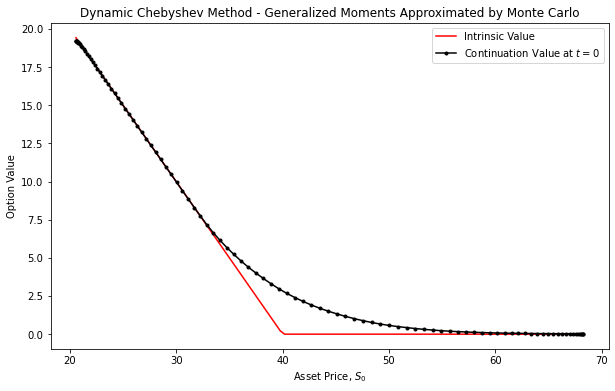

In [17]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the intrinsic value
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
intrinsic_value = np.maximum(option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, intrinsic_value, '-r', label='Intrinsic Value')

# Plot the continuation value at t=0
plt.plot(np.exp(xknots), option_pricing.C[:,0], '.-k', label='Continuation Value at $t=0$')

# Adding labels and title
plt.xlabel('Asset Price, $S_0$')
plt.ylabel('Option Value')
plt.title('Dynamic Chebyshev Method - Generalized Moments Approximated by Monte Carlo')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Checking Approximation for Incrasing Number of Knot Points

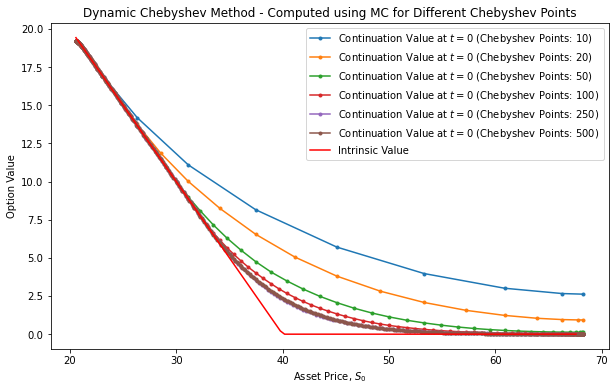

In [31]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100, 250, 500]

# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Loop over the array of Chebyshev points
for n_chebyshev_pol in chebyshev_points_array:
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=10_000, n=252, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # Calculate domain, xknots, and generalized moments
    domain = option_pricing.trunc_domain()
    xknots = option_pricing.nodal_points(domain)
    Γ = option_pricing.generalized_MC(domain, xknots)
    option_pricing.dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), option_pricing.C[:,0], '.-', label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value (only once, as it does not depend on the number of Chebyshev points)
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
intrinsic_value = np.maximum(option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, intrinsic_value, '-r', label='Intrinsic Value')

# Adding labels and title
plt.xlabel('Asset Price, $S_0$')
plt.ylabel('Option Value')
plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points')

# Adding a legend
plt.legend()

# Display the plot
plt.show()